In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import statsmodels.api as sm


In [18]:
# Carregar o DataFrame
df = pd.read_excel('C:/Users/Patyc/OneDrive/Desktop/Dissertation/Data/Skin_clean and treated/Skin_clean.xlsx')

# Converter a data para datetime e ordenar de forma crescente
df['Screening_date'] = pd.to_datetime(df['Screening_date'])
df = df.sort_values(by='Screening_date')

df

,Screening_date,Gender,Age,Personal_cancer_history,Family_cancer_history,Sun_exposure,Body_signs,Premalignant,Malignant,Phototype_2,Phototype_3,Phototype_4,Phototype_5,Phototype_6
5901,2022-03-03,1.0,NaN,0.0,1.0,1.0,1.0,0,0,0,0,0,0,0
5895,2022-03-03,0.0,NaN,0.0,0.0,1.0,0.0,1,0,0,1,0,0,0
5896,2022-03-03,1.0,NaN,0.0,0.0,1.0,1.0,0,0,0,1,0,0,0
5897,2022-03-03,0.0,NaN,0.0,0.0,1.0,0.0,0,0,0,1,0,0,0
5898,2022-03-03,1.0,NaN,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4481,2024-04-27,0.0,23.0,0.0,0.0,1.0,0.0,0,0,0,1,0,0,0
4480,2024-04-27,1.0,81.0,1.0,0.0,1.0,1.0,0,1,1,0,0,0,0
4479,2024-04-27,1.0,59.0,1.0,1.0,0.0,1.0,0,1,1,0,0,0,0
8049,2024-04-27,1.0,63.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0


In [19]:
# Lista das colunas que deseja eliminar
columns_to_drop = [
    'Gender', 'Age', 'Personal_cancer_history', 'Family_cancer_history',
    'Sun_exposure', 'Body_signs', 'Premalignant', 'Malignant',
    'Phototype_2', 'Phototype_3', 'Phototype_4', 'Phototype_5', 'Phototype_6'
]

# Eliminar as colunas do DataFrame
df = df.drop(columns=columns_to_drop)

df

df.columns

Index(['Screening_date'], dtype='object')

In [20]:
# Criar as variáveis exógenas (VVs) diretamente a partir da data dos rastreios
df['Year'] = df['Screening_date'].dt.year
df['Month'] = df['Screening_date'].dt.month
df['Week_day'] = df['Screening_date'].dt.day_name()
df['Year_week'] = df['Screening_date'].dt.isocalendar().week

df


,Screening_date,Year,Month,Week_day,Year_week
5901,2022-03-03,2022,3,Thursday,9
5895,2022-03-03,2022,3,Thursday,9
5896,2022-03-03,2022,3,Thursday,9
5897,2022-03-03,2022,3,Thursday,9
5898,2022-03-03,2022,3,Thursday,9
...,...,...,...,...,...
4481,2024-04-27,2024,4,Saturday,17
4480,2024-04-27,2024,4,Saturday,17
4479,2024-04-27,2024,4,Saturday,17
8049,2024-04-27,2024,4,Saturday,17


In [21]:
import pandas as pd

# Criar a coluna 'Semana' para agrupar por semana
df['Week'] = df['Screening_date'].dt.to_period('W').apply(lambda r: r.start_time)

# Definir o intervalo completo de semanas com base no mínimo e máximo das datas
full_weeks = pd.date_range(df['Screening_date'].min(), df['Screening_date'].max(), freq='W-MON')

# Agora agregue as variáveis corretamente
df_week = df.groupby('Week').agg({
    'Year': 'first',                           # Ano da primeira ocorrência na semana
    'Month': 'first',                           # Mês da primeira ocorrência na semana
    'Week_day': lambda x: x.mode()[0] if not x.empty else None,  # Dia da semana mais frequente
    'Year_week': 'first'                 # Semana do ano da primeira ocorrência na semana                  
}).reset_index()

# Adicionar a contagem de rastreios por semana
df_week['week_screenings'] = df.groupby('Week')['Screening_date'].size().values

# Reindexar para garantir que todas as semanas estejam incluídas
df_week = df_week.set_index('Week').reindex(full_weeks).reset_index()

# Preencher NaN com valores apropriados (por exemplo, 0 rastreios para semanas sem dados)
df_week['week_screenings'].fillna(0, inplace=True)

# Renomear colunas se necessário
df_week.rename(columns={'index': 'Week'}, inplace=True)

df_week


C:\Users\Patyc\AppData\Local\Temp\ipykernel_109468\1105261626.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_week['week_screenings'].fillna(0, inplace=True)


,Week,Year,Month,Week_day,Year_week,week_screenings
0,2022-03-07,NaN,NaN,NaN,<NA>,0.0
1,2022-03-14,2022.0,3.0,Saturday,11,62.0
2,2022-03-21,2022.0,3.0,Saturday,12,90.0
3,2022-03-28,NaN,NaN,NaN,<NA>,0.0
4,2022-04-04,2022.0,4.0,Saturday,14,139.0
...,...,...,...,...,...,...
107,2024-03-25,2024.0,3.0,Saturday,13,198.0
108,2024-04-01,2024.0,4.0,Saturday,14,242.0
109,2024-04-08,NaN,NaN,NaN,<NA>,0.0
110,2024-04-15,2024.0,4.0,Saturday,16,186.0


In [22]:
# Criar a coluna 'Semana' para agrupar por semana
df['Week'] = df['Screening_date'].dt.to_period('W').apply(lambda r: r.start_time)

# Agora agregue as VVs corretamente
df_week = df.groupby('Week').agg({
    'Year': 'first',                           # Ano da primeira ocorrência na semana
    'Month': 'first',                           # Mês da primeira ocorrência na semana
    'Week_day': lambda x: x.mode()[0], # Dia da semana mais frequente
    'Year_week': 'first'                 # Semana do ano da primeira ocorrência na semana                  
}).reset_index()

# Adicionar a contagem de rastreios por semana
df_week['week_screenings'] = df.groupby('Week')['Screening_date'].size().values

# Renomear a coluna 'Screening_date' para 'week_screenings'
df_week.rename(columns={'Screening_date': 'week_screenings'}, inplace=True)

df_week

,Week,Year,Month,Week_day,Year_week,week_screenings
0,2022-02-28,2022,3,Thursday,9,92
1,2022-03-14,2022,3,Saturday,11,62
2,2022-03-21,2022,3,Saturday,12,90
3,2022-04-04,2022,4,Saturday,14,139
4,2022-04-18,2022,4,Saturday,16,173
...,...,...,...,...,...,...
70,2024-03-18,2024,3,Saturday,12,168
71,2024-03-25,2024,3,Saturday,13,198
72,2024-04-01,2024,4,Saturday,14,242
73,2024-04-15,2024,4,Saturday,16,186


In [23]:
# Criar a coluna 'Semana' para agrupar por semana
df['Week'] = df['Screening_date'].dt.to_period('W').apply(lambda r: r.start_time)

# Agora agregue as VVs corretamente
df_week = df.groupby('Week').agg({
    'Year': 'first',                           # Ano da primeira ocorrência na semana
    'Month': 'first',                           # Mês da primeira ocorrência na semana
    'Week_day': lambda x: x.mode()[0], # Dia da semana mais frequente
    'Year_week': 'first'                 # Semana do ano da primeira ocorrência na semana                  
}).reset_index()

# Adicionar a contagem de rastreios por semana
df_week['week_screenings'] = df.groupby('Week')['Screening_date'].size().values

# Renomear a coluna 'Screening_date' para 'week_screenings'
df_week.rename(columns={'Screening_date': 'week_screenings'}, inplace=True)

# Remover as linhas onde week_screenings é igual a 0 (opcional)
df_week = df_week[df_week['week_screenings'] != 0]

df_week

,Week,Year,Month,Week_day,Year_week,week_screenings
0,2022-02-28,2022,3,Thursday,9,92
1,2022-03-14,2022,3,Saturday,11,62
2,2022-03-21,2022,3,Saturday,12,90
3,2022-04-04,2022,4,Saturday,14,139
4,2022-04-18,2022,4,Saturday,16,173
...,...,...,...,...,...,...
70,2024-03-18,2024,3,Saturday,12,168
71,2024-03-25,2024,3,Saturday,13,198
72,2024-04-01,2024,4,Saturday,14,242
73,2024-04-15,2024,4,Saturday,16,186


In [24]:
import pandas as pd

# Supondo que 'Week_day' é uma coluna com o nome dos dias da semana em formato de string
# Se 'Week_day' for um número ou código diferente para sábado, ajuste o filtro conforme necessário.

# Filtrar as linhas onde 'Week_day' é 'Saturday'
saturday_screenings = df_week[df_week['Week_day'] == 'Saturday']

# Exibir os valores de 'week_screenings' para os sábados
print(saturday_screenings[['Week', 'week_screenings']])

# Alternativamente, se quiser apenas os valores de 'week_screenings' sem as outras colunas:
print(saturday_screenings['week_screenings'].values)


         Week  week_screenings
1  2022-03-14               62
2  2022-03-21               90
3  2022-04-04              139
4  2022-04-18              173
5  2022-05-09                3
..        ...              ...
70 2024-03-18              168
71 2024-03-25              198
72 2024-04-01              242
73 2024-04-15              186
74 2024-04-22              184

[64 rows x 2 columns]
[ 62  90 139 173   3  64 101  83 148  95  86 102 183  99 101  45  95  94
  92  76  70  83  82  40   2  28   2   7  72  10  20   2  17 128  89 328
 407  80  93  98  57 141  38  86  11  85  99   6 101  29 193 188  68 288
 188  78 199 198 408 168 198 242 186 184]


In [25]:
# Criar a variável 'is_weekend' baseada na 'Week_day'
df_week['Saturday'] = df_week['Week_day'].apply(lambda x: 1 if x in ['Saturday'] else 0)

# Remover a coluna 'Week_day' se não for mais necessária (opcional)
df_week.drop(columns=['Week_day'], inplace=True)

# Exibir o DataFrame resultante
print(df_week)

         Week  Year  Month  Year_week  week_screenings  Saturday
0  2022-02-28  2022      3          9               92         0
1  2022-03-14  2022      3         11               62         1
2  2022-03-21  2022      3         12               90         1
3  2022-04-04  2022      4         14              139         1
4  2022-04-18  2022      4         16              173         1
..        ...   ...    ...        ...              ...       ...
70 2024-03-18  2024      3         12              168         1
71 2024-03-25  2024      3         13              198         1
72 2024-04-01  2024      4         14              242         1
73 2024-04-15  2024      4         16              186         1
74 2024-04-22  2024      4         17              184         1

[75 rows x 6 columns]


In [26]:
# Calcular variáveis adicionais após a agregação
df_week['Cumulative_total'] = df_week['week_screenings'].cumsum()
df_week['Weekly_diff'] = df_week['week_screenings'].diff().fillna(0)
df_week['Trend_4_Weeks'] = df_week['week_screenings'].rolling(window=4).mean()

In [27]:
df_week

,Week,Year,Month,Year_week,week_screenings,Saturday,Cumulative_total,Weekly_diff,Trend_4_Weeks
0,2022-02-28,2022,3,9,92,0,92,0.0,NaN
1,2022-03-14,2022,3,11,62,1,154,-30.0,NaN
2,2022-03-21,2022,3,12,90,1,244,28.0,NaN
3,2022-04-04,2022,4,14,139,1,383,49.0,95.75
4,2022-04-18,2022,4,16,173,1,556,34.0,116.00
...,...,...,...,...,...,...,...,...,...
70,2024-03-18,2024,3,12,168,1,7584,-240.0,243.25
71,2024-03-25,2024,3,13,198,1,7782,30.0,243.00
72,2024-04-01,2024,4,14,242,1,8024,44.0,254.00
73,2024-04-15,2024,4,16,186,1,8210,-56.0,198.50


In [28]:
df_week.columns

Index(['Week', 'Year', 'Month', 'Year_week', 'week_screenings', 'Saturday',
       'Cumulative_total', 'Weekly_diff', 'Trend_4_Weeks'],
      dtype='object')

In [29]:
# Eliminar linhas que contenham qualquer valor NaN
df_week = df_week.dropna()

# Exibir o DataFrame resultante para verificar se as linhas foram removidas
print(df_week)


         Week  Year  Month  Year_week  week_screenings  Saturday  \
3  2022-04-04  2022      4         14              139         1   
4  2022-04-18  2022      4         16              173         1   
5  2022-05-09  2022      5         19                3         1   
6  2022-05-23  2022      5         21               64         1   
7  2022-06-13  2022      6         24              101         1   
..        ...   ...    ...        ...              ...       ...   
70 2024-03-18  2024      3         12              168         1   
71 2024-03-25  2024      3         13              198         1   
72 2024-04-01  2024      4         14              242         1   
73 2024-04-15  2024      4         16              186         1   
74 2024-04-22  2024      4         17              184         1   

    Cumulative_total  Weekly_diff  Trend_4_Weeks  
3                383         49.0          95.75  
4                556         34.0         116.00  
5                559       -17

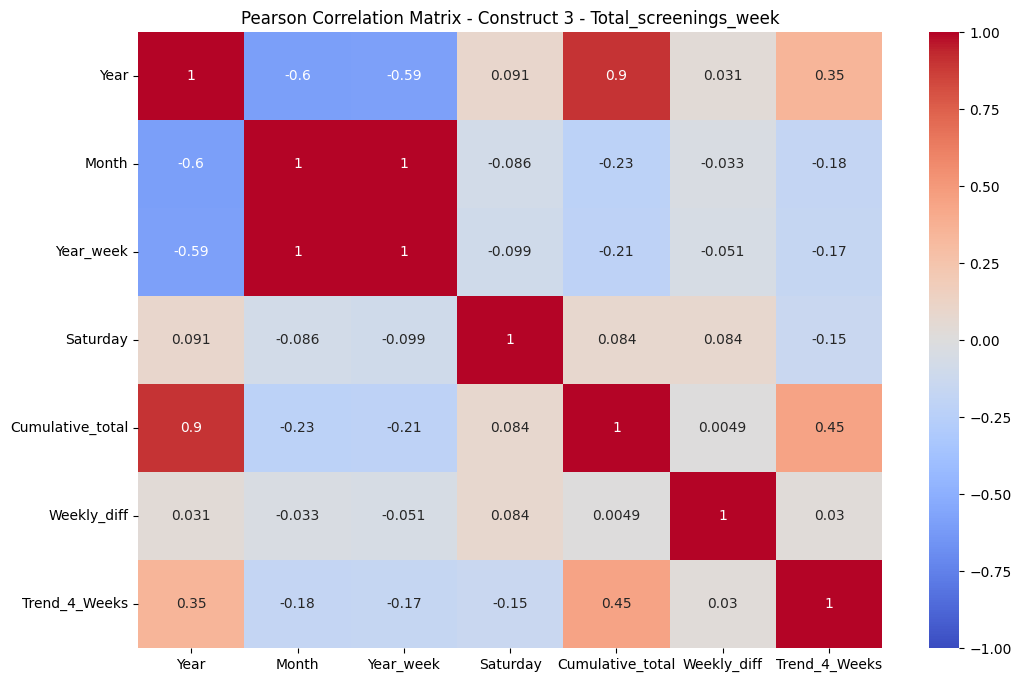

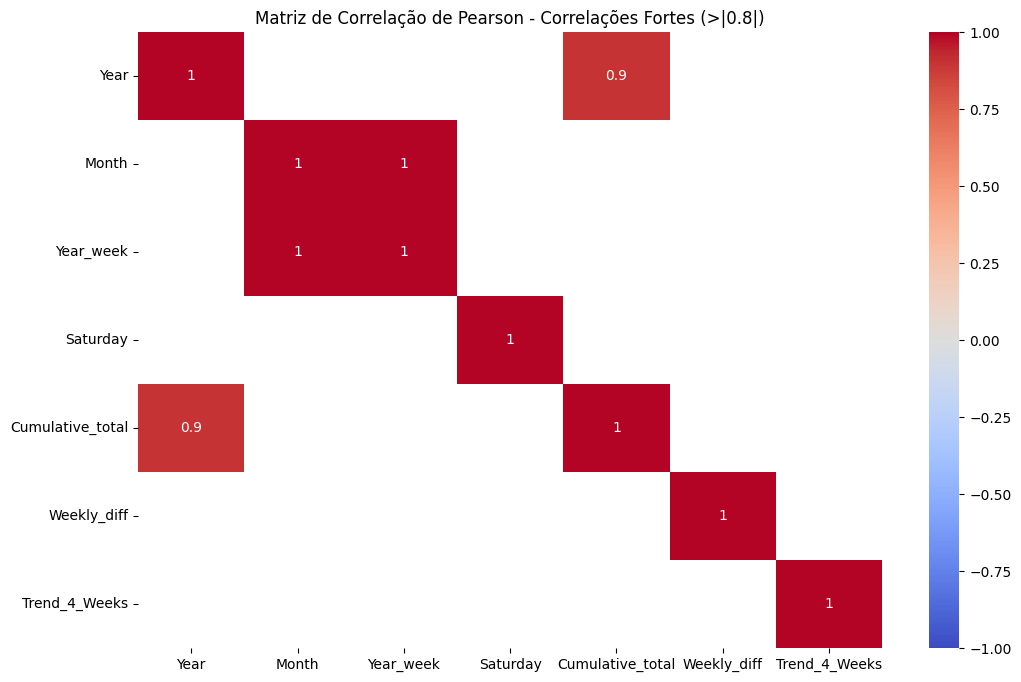

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Eliminar a primeira coluna (variável resposta)
# df_sem_resposta = df_week.iloc[:, 1:]

df_sem_resposta = df_week.drop(['week_screenings', 'Week'], axis=1)


# Calcular a correlação de Pearson
correlacao_pearson = df_sem_resposta.corr(method='pearson')

# Configuração do tamanho das figuras
plt.figure(figsize=(12, 8))
# Plotar a matriz de correlação com todas as correlações
sns.heatmap(correlacao_pearson, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Pearson Correlation Matrix - Construct 3 - Total_screenings_week')
plt.show()
# Filtrar as correlações fortes (acima de 0.8 ou abaixo de -0.8)
correlacao_forte = correlacao_pearson[(correlacao_pearson > 0.8) | (correlacao_pearson < -0.8)]
# Plotar a matriz de correlação com as correlações fortes
plt.figure(figsize=(12, 8))
sns.heatmap(correlacao_forte, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de Correlação de Pearson - Correlações Fortes (>|0.8|)')
plt.show()

In [34]:
# Remove the 'Total_Cumulativo' column from df_week
df_sem_resposta = df_sem_resposta.drop(columns=['Cumulative_total'])

# Remove the 'Total_Cumulativo' column from df_week
df_sem_resposta = df_sem_resposta.drop(columns=['Month'])

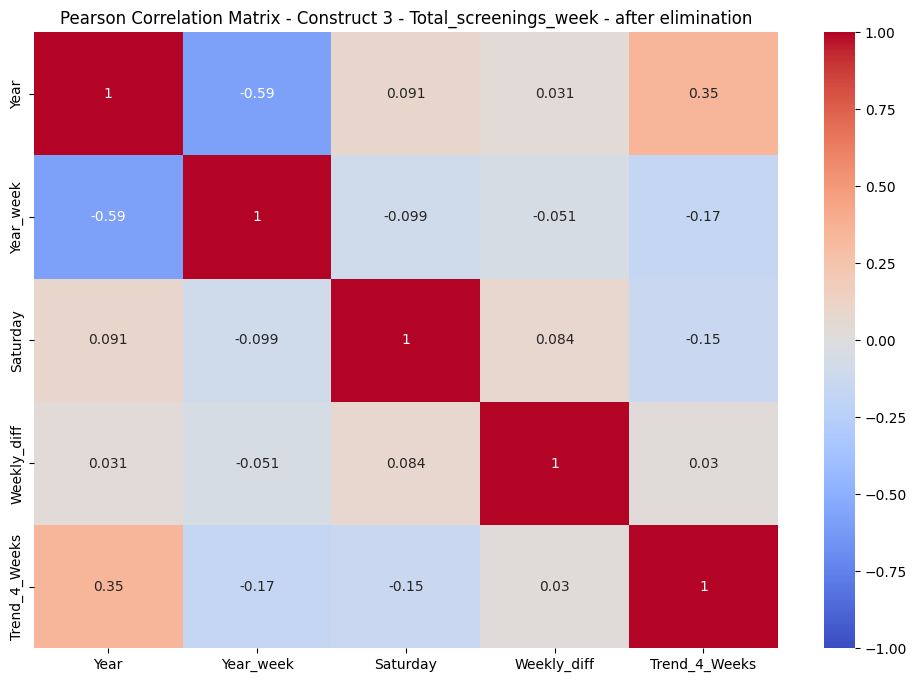

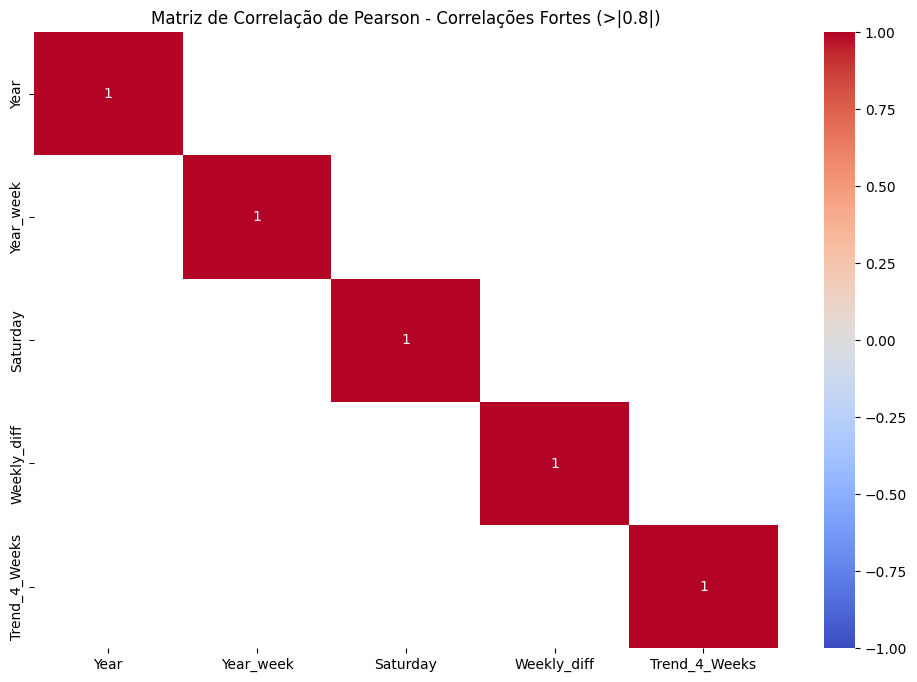

In [35]:
# Calcular a correlação de Pearson
correlacao_pearson = df_sem_resposta.corr(method='pearson')

# Configuração do tamanho das figuras
plt.figure(figsize=(12, 8))
# Plotar a matriz de correlação com todas as correlações
sns.heatmap(correlacao_pearson, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Pearson Correlation Matrix - Construct 3 - Total_screenings_week - after elimination')
plt.show()
# Filtrar as correlações fortes (acima de 0.8 ou abaixo de -0.8)
correlacao_forte = correlacao_pearson[(correlacao_pearson > 0.8) | (correlacao_pearson < -0.8)]
# Plotar a matriz de correlação com as correlações fortes
plt.figure(figsize=(12, 8))
sns.heatmap(correlacao_forte, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de Correlação de Pearson - Correlações Fortes (>|0.8|)')
plt.show()

In [12]:
# Selecionando as quatro colunas específicas do DataFrame df_week
selected_columns = df_week[['Week_day_Saturday', 'Week_day_Sunday', 'Week_day_Thursday', 'Week_day_Wednesday', 'Week_day_Monday']]

# Contando os valores 0 e 1 em cada uma dessas colunas
count_0_1 = selected_columns.apply(lambda x: x.value_counts()[[0, 1]])

# Exibindo o resultado
print(count_0_1)


   Week_day_Saturday  Week_day_Sunday  Week_day_Thursday  Week_day_Wednesday  \
0                 10               70                 68                  71   
1                 62                2                  4                   1   

   Week_day_Monday  
0               70  
1                2  


In [64]:
df = df_week

In [65]:
df

,Week,Year,Month,Year_week,week_screenings,Saturday,Total_Cumulativo,Weekly_diff,Trend_4_Weeks
3,2022-04-04,2022,4,14,139,1,383,49.0,95.75
4,2022-04-18,2022,4,16,173,1,556,34.0,116.00
5,2022-05-09,2022,5,19,3,1,559,-170.0,101.25
6,2022-05-23,2022,5,21,64,1,623,61.0,94.75
7,2022-06-13,2022,6,24,101,1,724,37.0,85.25
...,...,...,...,...,...,...,...,...,...
70,2024-03-18,2024,3,12,168,1,7584,-240.0,243.25
71,2024-03-25,2024,3,13,198,1,7782,30.0,243.00
72,2024-04-01,2024,4,14,242,1,8024,44.0,254.00
73,2024-04-15,2024,4,16,186,1,8210,-56.0,198.50


CORRELAÇÃO ENTRE VVS

                      Year     Month  Year_week  Saturday  Total_Cumulativo  \
Year              1.000000 -0.598446  -0.590330  0.090738          0.901199   
Month            -0.598446  1.000000   0.996399 -0.085815         -0.225500   
Year_week        -0.590330  0.996399   1.000000 -0.099492         -0.212195   
Saturday          0.090738 -0.085815  -0.099492  1.000000          0.084453   
Total_Cumulativo  0.901199 -0.225500  -0.212195  0.084453          1.000000   
Weekly_diff       0.031358 -0.032550  -0.051424  0.084366          0.004902   
Trend_4_Weeks     0.350742 -0.178037  -0.168215 -0.147349          0.450151   

                  Weekly_diff  Trend_4_Weeks  
Year                 0.031358       0.350742  
Month               -0.032550      -0.178037  
Year_week           -0.051424      -0.168215  
Saturday             0.084366      -0.147349  
Total_Cumulativo     0.004902       0.450151  
Weekly_diff          1.000000       0.030347  
Trend_4_Weeks        0.030347       1.

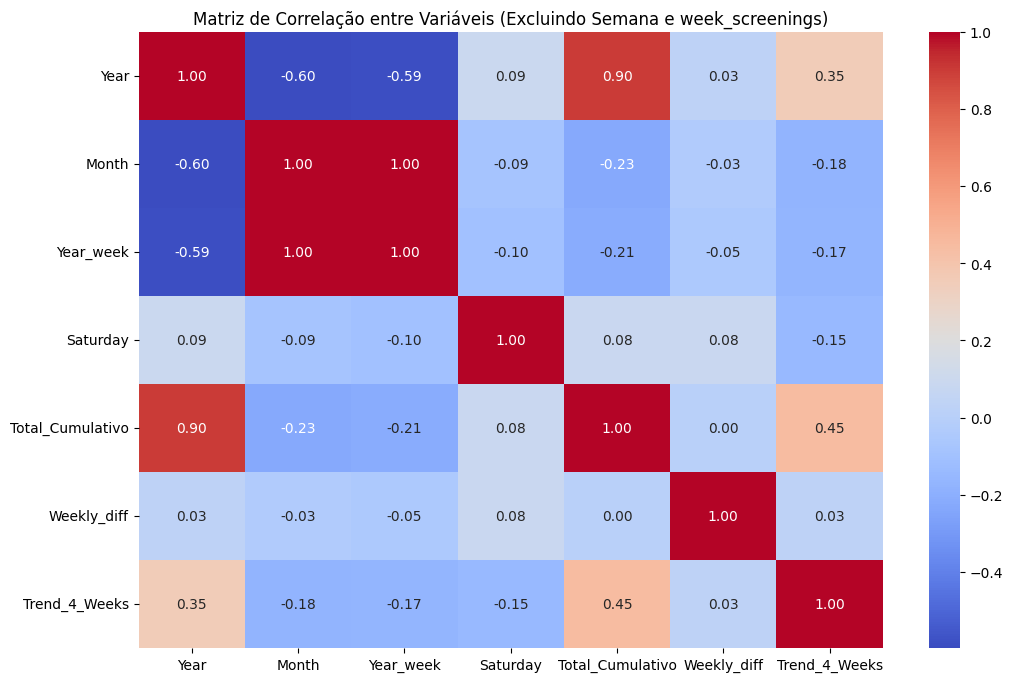

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

# Excluir as colunas 'Semana' e 'week_screenings' do DataFrame antes de calcular a correlação
df_filtered = df.drop(columns=['Week', 'week_screenings'])

# Calcular a matriz de correlação
correlation_matrix = df_filtered.corr()

# Exibir a matriz de correlação
print(correlation_matrix)

# Visualizar a matriz de correlação com um heatmap
plt.figure(figsize=(12,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação entre Variáveis (Excluindo Semana e week_screenings)')
plt.show()


In [67]:
# Remove the 'Total_Cumulativo' column from df_week
df = df.drop(columns=['Total_Cumulativo'])

df

,Week,Year,Month,Year_week,week_screenings,Saturday,Weekly_diff,Trend_4_Weeks
3,2022-04-04,2022,4,14,139,1,49.0,95.75
4,2022-04-18,2022,4,16,173,1,34.0,116.00
5,2022-05-09,2022,5,19,3,1,-170.0,101.25
6,2022-05-23,2022,5,21,64,1,61.0,94.75
7,2022-06-13,2022,6,24,101,1,37.0,85.25
...,...,...,...,...,...,...,...,...
70,2024-03-18,2024,3,12,168,1,-240.0,243.25
71,2024-03-25,2024,3,13,198,1,30.0,243.00
72,2024-04-01,2024,4,14,242,1,44.0,254.00
73,2024-04-15,2024,4,16,186,1,-56.0,198.50


In [68]:
# Remove the 'Total_Cumulativo' column from df_week
df = df.drop(columns=['Month'])

df

,Week,Year,Year_week,week_screenings,Saturday,Weekly_diff,Trend_4_Weeks
3,2022-04-04,2022,14,139,1,49.0,95.75
4,2022-04-18,2022,16,173,1,34.0,116.00
5,2022-05-09,2022,19,3,1,-170.0,101.25
6,2022-05-23,2022,21,64,1,61.0,94.75
7,2022-06-13,2022,24,101,1,37.0,85.25
...,...,...,...,...,...,...,...
70,2024-03-18,2024,12,168,1,-240.0,243.25
71,2024-03-25,2024,13,198,1,30.0,243.00
72,2024-04-01,2024,14,242,1,44.0,254.00
73,2024-04-15,2024,16,186,1,-56.0,198.50


In [69]:
# Supondo que o DataFrame seja chamado 'df'
df = df.dropna()

df.head(75)

,Week,Year,Year_week,week_screenings,Saturday,Weekly_diff,Trend_4_Weeks
3,2022-04-04,2022,14,139,1,49.0,95.75
4,2022-04-18,2022,16,173,1,34.0,116.00
5,2022-05-09,2022,19,3,1,-170.0,101.25
6,2022-05-23,2022,21,64,1,61.0,94.75
7,2022-06-13,2022,24,101,1,37.0,85.25
...,...,...,...,...,...,...,...
70,2024-03-18,2024,12,168,1,-240.0,243.25
71,2024-03-25,2024,13,198,1,30.0,243.00
72,2024-04-01,2024,14,242,1,44.0,254.00
73,2024-04-15,2024,16,186,1,-56.0,198.50


In [70]:
df.columns

Index(['Week', 'Year', 'Year_week', 'week_screenings', 'Saturday',
       'Weekly_diff', 'Trend_4_Weeks'],
      dtype='object')

In [19]:
import pandas as pd

# Assuming your DataFrame is named df
# Replace 'df' with your actual DataFrame name

# List of columns to analyze
columns_to_analyze = ['Week_day_Monday', 'Week_day_Saturday', 'Week_day_Sunday', 'Week_day_Thursday', 'Week_day_Wednesday']

# Loop through each column and print unique values and counts
for column in columns_to_analyze:
    print(f"Unique values and counts for {column}:")
    print(df[column].value_counts())
    print("\n")


Unique values and counts for Week_day_Monday:
Week_day_Monday
0    70
1     2
Name: count, dtype: int64


Unique values and counts for Week_day_Saturday:
Week_day_Saturday
1    62
0    10
Name: count, dtype: int64


Unique values and counts for Week_day_Sunday:
Week_day_Sunday
0    70
1     2
Name: count, dtype: int64


Unique values and counts for Week_day_Thursday:
Week_day_Thursday
0    68
1     4
Name: count, dtype: int64


Unique values and counts for Week_day_Wednesday:
Week_day_Wednesday
0    71
1     1
Name: count, dtype: int64




# MULTIPLE LINEAR REGRESSION MODEL

In [71]:
df.columns

Index(['Week', 'Year', 'Year_week', 'week_screenings', 'Saturday',
       'Weekly_diff', 'Trend_4_Weeks'],
      dtype='object')

In [72]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Assuming your DataFrame is named 'df'
X = df[['Year', 'Year_week', 'Saturday', 'Weekly_diff', 'Trend_4_Weeks']]
y = df['week_screenings']

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Assuming your DataFrame is named 'df'
X = df[['Year', 'Year_week', 'Weekly_diff', 'Trend_4_Weeks', 'Week_day_Monday', 'Week_day_Saturday', 'Week_day_Sunday', 'Week_day_Thursday', 'Week_day_Wednesday']]
y = df['week_screenings']

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [127]:
# Assuming your DataFrame is named 'df' and has a date column named 'date'
df['Week'] = pd.to_datetime(df['Week'])

# Split the data into training and testing sets based on the date '2024-03-01'
train_df = df[df['Week'] < '2024-03-11']
test_df = df[df['Week'] >= '2024-03-11']

# Define X and y for both train and test sets
X_train = train_df[['Year', 'Year_week', 'Weekly_diff', 'Trend_4_Weeks', 'Week_day_Monday', 'Week_day_Saturday', 'Week_day_Sunday', 'Week_day_Thursday', 'Week_day_Wednesday']]
y_train = train_df['week_screenings']

# Definir X e y para o conjunto de teste
X_test = test_df[['Year', 'Year_week', 'Weekly_diff', 'Trend_4_Weeks', 'Week_day_Monday', 'Week_day_Saturday', 'Week_day_Sunday', 'Week_day_Thursday', 'Week_day_Wednesday']]
y_test = test_df['week_screenings']

In [74]:
# Create and fit the Linear Regression model
model_mlr = LinearRegression()
model_mlr.fit(X_train, y_train)

# Make predictions on the test set
y_pred_mlr = model_mlr.predict(X_test)

In [75]:
# Calcular e imprimir as métricas de avaliação
mae = mean_absolute_error(y_test, y_pred_mlr)
mse = mean_squared_error(y_test, y_pred_mlr)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_mlr)
me = np.mean(y_test - y_pred_mlr)
mav = np.mean(np.abs(y_test))
mpv = np.mean(np.abs((y_test - y_pred_mlr) / y_test))
rme = np.mean((y_test - y_pred_mlr) / y_test)
rmae = np.mean(np.abs(y_test - y_pred_mlr) / np.abs(y_test))

print("Modelo: LR")
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')
print(f'ME: {me}')
print(f'MAV: {mav}')
print(f'MPV: {mpv}')
print(f'RME: {rme}')
print(f'RMAE: {rmae}')

# Modelo: LR suffle
# MAE: 34.541699842056246
# MSE: 1676.9215421279944
# RMSE: 40.95023250395526
# R2: 0.7790837117787726
# ME: 7.3207219215564425
# MAV: 187.66666666666666
# MPV: 0.19913637717153318
# RME: 0.03900969740985151
# RMAE: 0.19913637717153318

# Modelo: LR split
# MAE: 41.526407501484606
# MSE: 2355.1408809579484
# RMSE: 48.52979374526486
# R2: 0.6531626997754727
# ME: -4.239963898065223
# MAV: 231.0
# MPV: 0.17574634477318166
# RME: -0.04573881080358431
# RMAE: 0.17574634477318166




Modelo: LR
MAE: 35.30576961232267
MSE: 1773.9711234532303
RMSE: 42.118536577773334
R2: 0.7662984783965426
ME: 13.248698783906487
MAV: 187.66666666666666
MPV: 0.2122733233456681
RME: 0.08240409109818152
RMAE: 0.2122733233456681


In [76]:
# Extraindo os coeficientes (sem o intercepto)
coefficients = model_mlr.coef_

# Criando o DataFrame com nomes das características e coeficientes
features_importance_df = pd.DataFrame({
    'Feature': list(X.columns),  # Lista apenas as características (sem o intercepto)
    'Coeff': coefficients,
})

# Calculando a Importância Relativa normalizando os coeficientes
features_importance_df['Relative_Importance'] = (np.abs(features_importance_df['Coeff']) / np.abs(features_importance_df['Coeff']).sum()) * 100

# Ordenando o DataFrame por Importância Relativa em ordem decrescente
features_importance_df = features_importance_df.sort_values(by='Relative_Importance', ascending=False)

# Exportando o DataFrame para um arquivo Excel
features_importance_df.to_excel('features_importance_without_intercept.xlsx', index=False)

# Exibindo o DataFrame
print(features_importance_df)



         Feature     Coeff  Relative_Importance
2       Saturday -6.515181            50.133956
0           Year -4.704982            36.204576
4  Trend_4_Weeks  0.993007             7.641131
3    Weekly_diff  0.491005             3.778257
1      Year_week -0.291370             2.242080


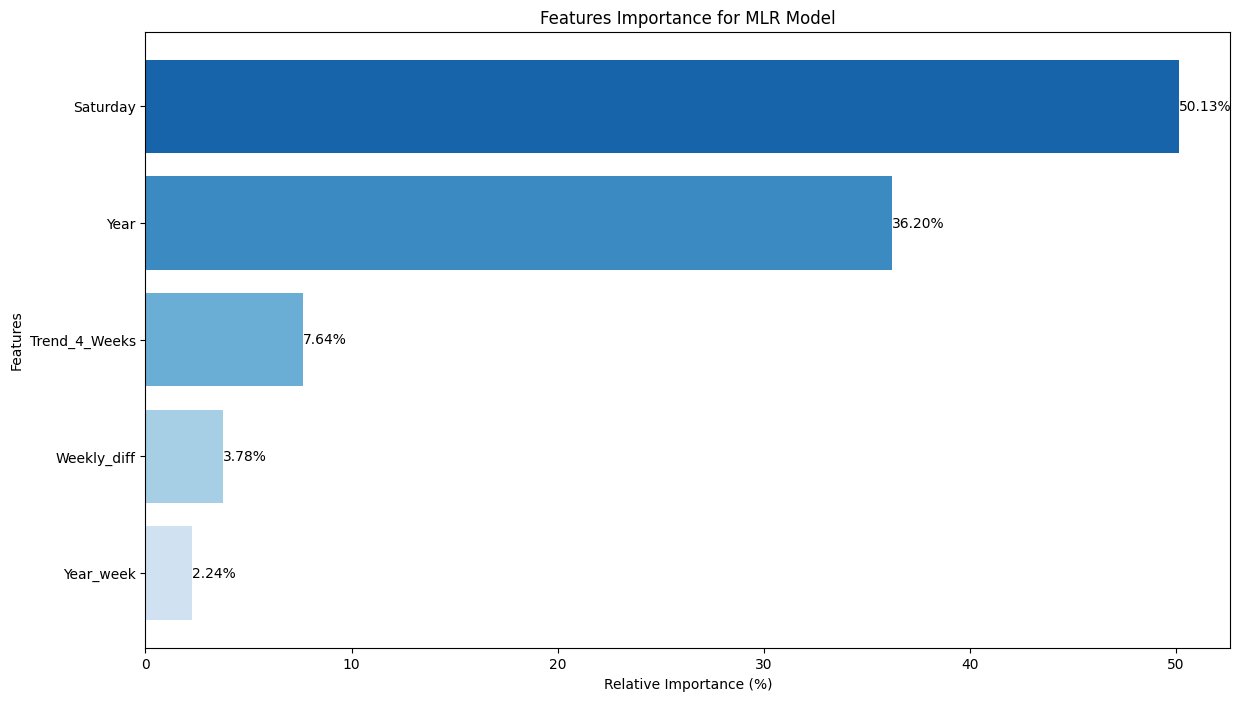

In [77]:
import matplotlib.pyplot as plt
import numpy as np

# Gerando um gradiente de azul do mais escuro para o mais claro
colors = plt.cm.Blues(np.linspace(0.8, 0.2, len(features_importance_df)))

plt.figure(figsize=(14, 8))
bars = plt.barh(features_importance_df['Feature'], features_importance_df['Relative_Importance'], color=colors)

plt.title('Features Importance for MLR Model')
plt.xlabel('Relative Importance (%)')
plt.ylabel('Features')

# Adicionando o percentual próximo às barras
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}%', va='center', fontsize=10)

plt.gca().invert_yaxis()  # Inverter o eixo y para ter a maior importância no topo
plt.show()


# GLM MODEL

In [31]:
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families import Gaussian
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm

Kernel

In [32]:
# Definir o grau do polinômio
degree = 2

# Criar o transformador polinomial
poly = PolynomialFeatures(degree)

# Ajustar e transformar os dados de treino
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Adicionar uma constante aos dados transformados
X_train_poly_sm = sm.add_constant(X_train_poly)
X_test_poly_sm = sm.add_constant(X_test_poly)

# Ajustar o modelo GLM com família Gaussian
model_glm = GLM(y_train, X_train_poly_sm, family=Gaussian()).fit()

# Obter o resumo do modelo
print(model_glm.summary())

# Fazer previsões no conjunto de teste
y_pred = model_glm.predict(X_test_poly_sm)

# Calcular e imprimir as métricas de avaliação
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
me = np.mean(y_test - y_pred)
mav = np.mean(np.abs(y_test))
mpv = np.mean(np.abs((y_test - y_pred) / y_test))
rme = np.mean((y_test - y_pred) / y_test)
rmae = np.mean(np.abs(y_test - y_pred) / np.abs(y_test))

                 Generalized Linear Model Regression Results                  
Dep. Variable:        week_screenings   No. Observations:                   60
Model:                            GLM   Df Residuals:                       36
Model Family:                Gaussian   Df Model:                           23
Link Function:               Identity   Scale:                          605.07
Method:                          IRLS   Log-Likelihood:                -261.97
Date:                Mon, 02 Sep 2024   Deviance:                       21783.
Time:                        14:19:56   Pearson chi2:                 2.18e+04
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9999
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.884e+07   4.04e+07     -0.466      0.6

In [33]:
print("Modelo: GLM com kernel polinomial")
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')
print(f'ME: {me}')
print(f'MAV: {mav}')
print(f'MPV: {mpv}')
print(f'RME: {rme}')
print(f'RMAE: {rmae}')

# Modelo: GLM com kernel polinomial shuffle
# MAE: 65.83115585784748
# MSE: 8377.464905019102
# RMSE: 91.52849231260778
# R2: -0.10364045366837926
# ME: 4.957587303085128
# MAV: 187.66666666666666
# MPV: 0.35619468481676575
# RME: 0.09585055970762935
# RMAE: 0.35619468481676575

# Modelo: GLM com kernel polinomial split
# MAE: 47.14718534380095
# MSE: 3345.412489277965
# RMSE: 57.83954088059452
# R2: 0.5073272069199404
# ME: 43.75232375103761
# MAV: 231.0
# MPV: 0.19966844709435713
# RME: 0.18252268147434023
# RMAE: 0.19966844709435713


Modelo: GLM com kernel polinomial
MAE: 41.78751555457711
MSE: 3295.5314354099896
RMSE: 57.40671942734569
R2: 0.5439074673021679
ME: -33.617067939291395
MAV: 200.41666666666666
MPV: 0.26679144950727596
RME: -0.2273988222119163
RMAE: 0.26679144950727596


In [47]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families import Gaussian
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Definir o grau do polinômio
degree = 2

# Criar o transformador polinomial
poly = PolynomialFeatures(degree)

# Ajustar e transformar os dados de treino
X_poly = poly.fit_transform(X)  # Transformando todos os dados disponíveis

# Adicionar uma constante aos dados transformados
X_poly_sm = sm.add_constant(X_poly)

# Definir o número de splits para a validação cruzada
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Listas para armazenar as métricas
mae_scores = []
rmse_scores = []
r2_scores = []

# Realizar a validação cruzada mantendo a sequência temporal
for train_index, test_index in tscv.split(X_poly_sm):
    X_train_cv, X_test_cv = X_poly_sm[train_index], X_poly_sm[test_index]
    y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]
    
    # Ajustar o modelo GLM com família Gaussian
    model_glm = GLM(y_train_cv, X_train_cv, family=Gaussian()).fit()
    
    # Fazer previsões no conjunto de teste atual
    y_pred_cv = model_glm.predict(X_test_cv)
    
    # Calcular MAE, RMSE e R²
    mae = mean_absolute_error(y_test_cv, y_pred_cv)
    rmse = np.sqrt(mean_squared_error(y_test_cv, y_pred_cv))
    r2 = r2_score(y_test_cv, y_pred_cv)
    
    # Armazenar as métricas
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

# Imprimir os scores de CV para cada métrica
print("Cross-Validation MAE Scores:", mae_scores)
print("Mean MAE:", np.mean(mae_scores))
print("Cross-Validation RMSE Scores:", rmse_scores)
print("Mean RMSE:", np.mean(rmse_scores))
print("Cross-Validation R2 Scores:", r2_scores)
print("Mean R2:", np.mean(r2_scores))

# Ajustar o modelo GLM no conjunto de dados completo
model_glm_final = GLM(y, X_poly_sm, family=Gaussian()).fit()

# Obter o resumo do modelo final
print(model_glm_final.summary())

# Fazer previsões no conjunto completo
y_pred_final = model_glm_final.predict(X_poly_sm)

# Calcular e imprimir as métricas no conjunto completo
mae_final = mean_absolute_error(y, y_pred_final)
rmse_final = np.sqrt(mean_squared_error(y, y_pred_final))
r2_final = r2_score(y, y_pred_final)

print("Final Model MAE:", mae_final)
print("Final Model RMSE:", rmse_final)
print("Final Model R2:", r2_final)

# Final Model MAE: 17.560717660586754
# Final Model RMSE: 24.1157848216495
# Final Model R2: 0.9233128587836975


Cross-Validation MAE Scores: [3406.5658522261933, 38.25519333680113, 64603.14378740592, 55.296842909277395, 41.851244531467664]
Mean MAE: 13629.02258408193
Cross-Validation RMSE Scores: [4044.941568899442, 47.48911114279417, 107004.93194612201, 72.81710818123054, 57.48197024548554]
Mean RMSE: 22245.532340918195
Cross-Validation R2 Scores: [-16998.505978503978, -0.4843251998843747, -987926.7742219478, -0.456295439859417, 0.5427109582034348]
Mean R2: -200985.13562202666
                 Generalized Linear Model Regression Results                  
Dep. Variable:        week_screenings   No. Observations:                   72
Model:                            GLM   Df Residuals:                       48
Model Family:                Gaussian   Df Model:                           23
Link Function:               Identity   Scale:                          872.38
Method:                          IRLS   Log-Likelihood:                -331.33
Date:                Sat, 31 Aug 2024   Deviance:    

c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:898: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sum(resid / self.family.variance(mu)) / self.df_resid
c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)


In [56]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families import Gaussian
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Definir o grau do polinômio
degree = 2

# Criar o transformador polinomial
poly = PolynomialFeatures(degree)

# Ajustar e transformar os dados de treino
X_poly = poly.fit_transform(X)  # Transformando todos os dados disponíveis

# Adicionar uma constante aos dados transformados
X_poly_sm = sm.add_constant(X_poly)

# Definir o número de splits para a validação cruzada
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Listas para armazenar as métricas
mae_scores = []
rmse_scores = []
r2_scores = []

# Realizar a validação cruzada mantendo a sequência temporal
for i, (train_index, test_index) in enumerate(tscv.split(X_poly_sm), start=1):
    X_train_cv, X_test_cv = X_poly_sm[train_index], X_poly_sm[test_index]
    y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]
    
    # Ajustar o modelo GLM com família Gaussian
    model_glm = GLM(y_train_cv, X_train_cv, family=Gaussian()).fit()
    
    # Fazer previsões no conjunto de teste atual
    y_pred_cv = model_glm.predict(X_test_cv)
    
    # Calcular MAE, RMSE e R²
    mae = mean_absolute_error(y_test_cv, y_pred_cv)
    rmse = np.sqrt(mean_squared_error(y_test_cv, y_pred_cv))
    r2 = r2_score(y_test_cv, y_pred_cv)
    
    # Armazenar as métricas
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(r2)
    
    # Imprimir as métricas para o fold atual
    print(f"Fold {i} - MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")

# Calcular as métricas médias de CV
mean_mae = np.mean(mae_scores)
mean_rmse = np.mean(rmse_scores)
mean_r2 = np.mean(r2_scores)

# Imprimir as métricas médias da CV
print("\nMean Cross-Validation MAE:", mean_mae)
print("Mean Cross-Validation RMSE:", mean_rmse)
print("Mean Cross-Validation R2:", mean_r2)


Fold 1 - MAE: 3406.5659, RMSE: 4044.9416, R2: -16998.5060
Fold 2 - MAE: 38.2552, RMSE: 47.4891, R2: -0.4843
Fold 3 - MAE: 64603.1438, RMSE: 107004.9319, R2: -987926.7742
Fold 4 - MAE: 55.2968, RMSE: 72.8171, R2: -0.4563
Fold 5 - MAE: 41.8512, RMSE: 57.4820, R2: 0.5427

Mean Cross-Validation MAE: 13629.02258408193
Mean Cross-Validation RMSE: 22245.532340918195
Mean Cross-Validation R2: -200985.13562202666


c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:898: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sum(resid / self.family.variance(mu)) / self.df_resid
c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)


features importances:

In [48]:
import pandas as pd
import numpy as np

# Supondo que 'model_glm_final' seja o seu modelo ajustado e 'poly' seja o objeto PolynomialFeatures

# Obter os coeficientes originais e seus valores absolutos
coefficients = model_glm_final.params
coefficients_abs = np.abs(coefficients)

# Calcular a importância relativa proporcional ao valor absoluto dos coeficientes
relative_importance = (coefficients_abs / coefficients_abs.sum()) * 100

# Criar um DataFrame para organizar os coeficientes e as importâncias relativas
feature_importance = pd.DataFrame({
    'Feature': poly.get_feature_names_out(X.columns),  # Nomes das features após a transformação polinomial
    'Coefficient': coefficients,  # Coeficientes originais
    'Relative Importance': relative_importance  # Importância relativa proporcional
})

# Ordenar as features pela importância relativa
feature_importance = feature_importance.sort_values(by='Relative Importance', ascending=False)

# Exibir as importâncias relativas e os coeficientes
print(feature_importance)

# Salvar o DataFrame completo em um arquivo Excel
feature_importance.to_excel('feature_importance.xlsx', index=False)

print("Feature importance with coefficients has been saved to 'feature_importance.xlsx'.")


                                              Feature   Coefficient  \
x4                             Dia_da_Semana_Saturday  2.120881e+07   
x34                          Dia_da_Semana_Saturday^2  2.120872e+07   
const                                               1  2.118791e+07   
x1                                                Ano -4.192391e+04   
x13                        Ano Dia_da_Semana_Saturday -2.101534e+04   
x2                                      Semana_do_Ano  1.108979e+03   
x3                               Dia_da_Semana_Monday  1.029985e+03   
x23              Semana_do_Ano Dia_da_Semana_Thursday  9.922927e+02   
x33          Dia_da_Semana_Monday Tendência_4_Semanas  8.579994e+02   
x39        Dia_da_Semana_Saturday Tendência_4_Semanas  4.593286e+02   
x48        Dia_da_Semana_Thursday Tendência_4_Semanas  4.078114e+02   
x21              Semana_do_Ano Dia_da_Semana_Saturday  3.803627e+02   
x8                                  Diferença_Semanal  3.413194e+02   
x32   

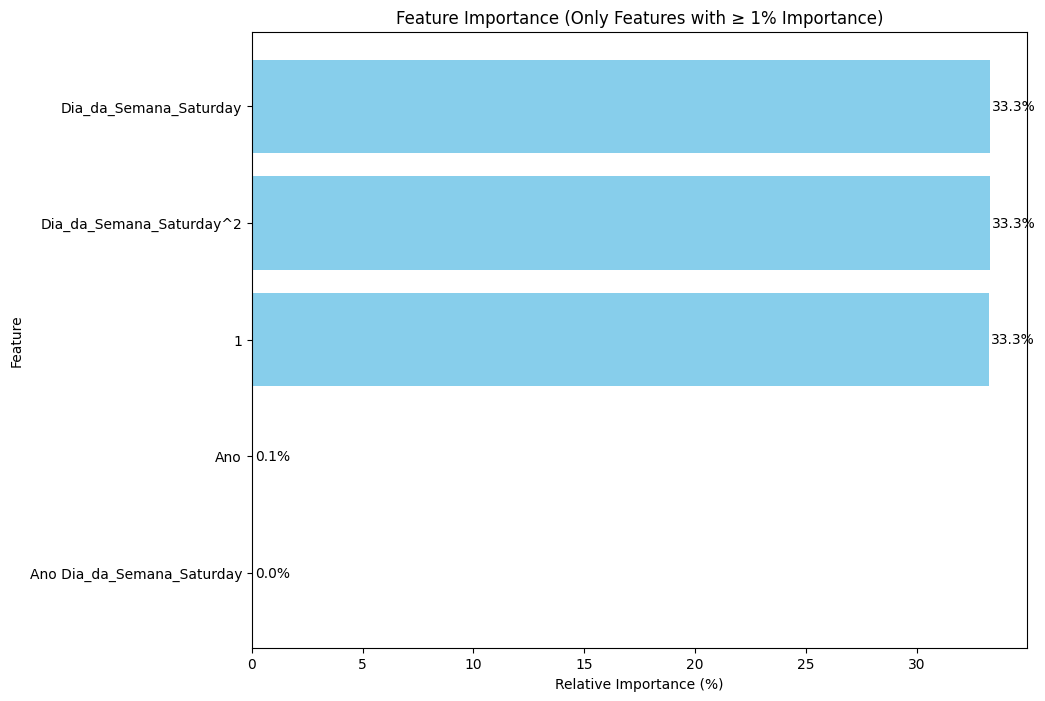

In [49]:
import matplotlib.pyplot as plt

# Filtrar as features que têm pelo menos 1% de importância relativa
filtered_features = feature_importance[feature_importance['Relative Importance'] >= 0.01]

# Ordenar as features filtradas por importância relativa
filtered_features = filtered_features.sort_values(by='Relative Importance', ascending=True)

# Criar o gráfico de barras horizontais
plt.figure(figsize=(10, 8))
plt.barh(filtered_features['Feature'], filtered_features['Relative Importance'], color='skyblue')

# Adicionar rótulos de porcentagem em cada barra
for index, value in enumerate(filtered_features['Relative Importance']):
    plt.text(value + 0.1, index, f"{value:.1f}%", va='center')

# Configurar títulos e labels
plt.xlabel('Relative Importance (%)')
plt.ylabel('Feature')
plt.title('Feature Importance (Only Features with ≥ 1% Importance)')

# Mostrar o gráfico
plt.show()


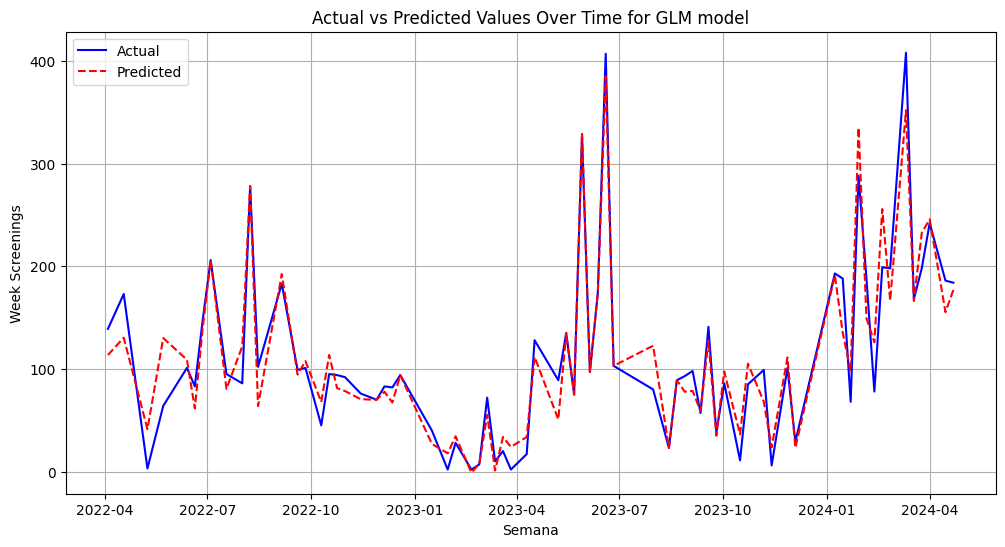

In [40]:
import matplotlib.pyplot as plt

# Create a DataFrame to compare predicted vs actual values
comparison_df = pd.DataFrame({
    'Semana': df['Semana'],
    'Actual': y,
    'Predicted': y_pred_final
})

# Plotting the actual vs predicted values over time
plt.figure(figsize=(12, 6))
plt.plot(comparison_df['Semana'], comparison_df['Actual'], label='Actual', color='blue')
plt.plot(comparison_df['Semana'], comparison_df['Predicted'], label='Predicted', color='red', linestyle='--')
plt.xlabel('Semana')
plt.ylabel('Week Screenings')
plt.title('Actual vs Predicted Values Over Time for GLM model')
plt.legend()
plt.grid(True)
plt.show()



# SVR MODEL

In [78]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

Kernel gaussiano

In [152]:
# Definir o modelo SVR com kernel RBF
model_svr = SVR(kernel='rbf', C=1.0, gamma='scale')

# Ajustar o modelo
model_svr.fit(X_train, y_train)

# "Summary" of the model
print(f"Support Vectors: {model_svr.support_vectors_}")
print(f"Number of Support Vectors: {model_svr.n_support_}")
print(f"Dual Coefficients: {model_svr.dual_coef_}")

# Fazer previsões no conjunto de teste
y_pred = model_svr.predict(X_test)

# Calcular e imprimir as métricas de avaliação
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
me = np.mean(y_test - y_pred)
mav = np.mean(np.abs(y_test))
mpv = np.mean(np.abs((y_test - y_pred) / y_test))
rme = np.mean((y_test - y_pred) / y_test)
rmae = np.mean(np.abs(y_test - y_pred) / np.abs(y_test))

Support Vectors: [[ 2.0220e+03  1.4000e+01  4.9000e+01  9.5750e+01  0.0000e+00  1.0000e+00
   0.0000e+00  0.0000e+00  0.0000e+00]
 [ 2.0220e+03  1.6000e+01  3.4000e+01  1.1600e+02  0.0000e+00  1.0000e+00
   0.0000e+00  0.0000e+00  0.0000e+00]
 [ 2.0220e+03  1.9000e+01 -1.7000e+02  1.0125e+02  0.0000e+00  1.0000e+00
   0.0000e+00  0.0000e+00  0.0000e+00]
 [ 2.0220e+03  2.1000e+01  6.1000e+01  9.4750e+01  0.0000e+00  1.0000e+00
   0.0000e+00  0.0000e+00  0.0000e+00]
 [ 2.0220e+03  2.4000e+01  3.7000e+01  8.5250e+01  0.0000e+00  1.0000e+00
   0.0000e+00  0.0000e+00  0.0000e+00]
 [ 2.0220e+03  2.5000e+01 -1.8000e+01  6.2750e+01  0.0000e+00  1.0000e+00
   0.0000e+00  0.0000e+00  0.0000e+00]
 [ 2.0220e+03  2.6000e+01  6.5000e+01  9.9000e+01  0.0000e+00  1.0000e+00
   0.0000e+00  0.0000e+00  0.0000e+00]
 [ 2.0220e+03  2.7000e+01  5.8000e+01  1.3450e+02  1.0000e+00  0.0000e+00
   0.0000e+00  0.0000e+00  0.0000e+00]
 [ 2.0220e+03  2.9000e+01 -1.1100e+02  1.3300e+02  0.0000e+00  1.0000e+00
   0.

In [153]:
print("Modelo: SVR")
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')
print(f'ME: {me}')
print(f'MAV: {mav}')
print(f'MPV: {mpv}')
print(f'RME: {rme}')
print(f'RMAE: {rmae}')

# Modelo: SVR shuffle
# MAE: 110.90723865119116
# MSE: 17318.33077454248
# RMSE: 131.59912907972637
# R2: -1.2815028949084608
# ME: 98.69759511702728
# MAV: 187.66666666666666
# MPV: 0.6246328362821879
# RME: 0.2900178062146467
# RMAE: 0.6246328362821879

# Modelo: SVR split
# MAE: 140.33759493597523
# MSE: 26466.370236394767
# RMSE: 162.68488017143684
# R2: -2.8976540527801435
# ME: 140.33759493597523
# MAV: 231.0
# MPV: 0.5710494020446398
# RME: 0.5710494020446398
# RMAE: 0.5710494020446398

Modelo: SVR
MAE: 110.90723865119116
MSE: 17318.33077454248
RMSE: 131.59912907972637
R2: -1.2815028949084608
ME: 98.69759511702728
MAV: 187.66666666666666
MPV: 0.6246328362821879
RME: 0.2900178062146467
RMAE: 0.6246328362821879


Linear Kernel

In [79]:
# Definir o modelo SVR com kernel RBF
model_svr_linear = SVR(kernel='linear', C=1.0)

# Ajustar o modelo
model_svr_linear.fit(X_train, y_train)

# "Summary" of the model
print(f"Support Vectors: {model_svr_linear.support_vectors_}")
print(f"Number of Support Vectors: {model_svr_linear.n_support_}")
print(f"Dual Coefficients: {model_svr_linear.dual_coef_}")
print(f"Intercept (Constante): {model_svr_linear.intercept_}")

# Fazer previsões no conjunto de teste
y_pred_svr = model_svr_linear.predict(X_test)

# Calcular e imprimir as métricas de avaliação
mae = mean_absolute_error(y_test, y_pred_svr)
mse = mean_squared_error(y_test, y_pred_svr)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_svr)
me = np.mean(y_test - y_pred_svr)
mav = np.mean(np.abs(y_test))
mpv = np.mean(np.abs((y_test - y_pred_svr) / y_test))
rme = np.mean((y_test - y_pred_svr) / y_test)
rmae = np.mean(np.abs(y_test - y_pred_svr) / np.abs(y_test))

Support Vectors: [[ 2.0220e+03  1.4000e+01  1.0000e+00  4.9000e+01  9.5750e+01]
 [ 2.0220e+03  1.6000e+01  1.0000e+00  3.4000e+01  1.1600e+02]
 [ 2.0220e+03  1.9000e+01  1.0000e+00 -1.7000e+02  1.0125e+02]
 [ 2.0220e+03  2.1000e+01  1.0000e+00  6.1000e+01  9.4750e+01]
 [ 2.0220e+03  2.4000e+01  1.0000e+00  3.7000e+01  8.5250e+01]
 [ 2.0220e+03  2.5000e+01  1.0000e+00 -1.8000e+01  6.2750e+01]
 [ 2.0220e+03  2.6000e+01  1.0000e+00  6.5000e+01  9.9000e+01]
 [ 2.0220e+03  2.7000e+01  0.0000e+00  5.8000e+01  1.3450e+02]
 [ 2.0220e+03  2.9000e+01  1.0000e+00 -1.1100e+02  1.3300e+02]
 [ 2.0220e+03  3.1000e+01  1.0000e+00 -9.0000e+00  1.3375e+02]
 [ 2.0220e+03  3.2000e+01  0.0000e+00  1.9200e+02  1.6625e+02]
 [ 2.0220e+03  3.3000e+01  1.0000e+00 -1.7600e+02  1.4025e+02]
 [ 2.0220e+03  3.6000e+01  1.0000e+00  8.1000e+01  1.6225e+02]
 [ 2.0220e+03  3.8000e+01  1.0000e+00 -8.4000e+01  1.6550e+02]
 [ 2.0220e+03  3.9000e+01  1.0000e+00  2.0000e+00  1.2125e+02]
 [ 2.0220e+03  4.1000e+01  1.0000e+00 

In [81]:
print("Modelo: SVR")
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')
print(f'ME: {me}')
print(f'MAV: {mav}')
print(f'MPV: {mpv}')
print(f'RME: {rme}')
print(f'RMAE: {rmae}')


# Modelo: SVR
# MAE: 36.80114433649602
# MSE: 1993.3726587922117
# RMSE: 44.64720213845669
# R2: 0.737394697510277
# ME: -11.425072874576776
# MAV: 187.66666666666666
# MPV: 0.2267038474506203
# RME: -0.05520670526089726
# RMAE: 0.2267038474506203

# Modelo: SVR split
# MAE: 47.204114283484806
# MSE: 3245.8529098043055
# RMSE: 56.972387257375004
# R2: 0.5219891645273714
# ME: -27.709668529682613
# MAV: 231.0
# MPV: 0.20622807026779277
# RME: -0.15844756596925796
# RMAE: 0.20622807026779277

Modelo: SVR
MAE: 36.82722654930653
MSE: 2005.4101657789204
RMSE: 44.781806191565344
R2: 0.7358088860717966
ME: -11.884455579492407
MAV: 187.66666666666666
MPV: 0.22625592326169292
RME: -0.06025407137384431
RMAE: 0.22625592326169292


In [86]:
# Check feature importance
if hasattr(model_svr_linear, 'coef_'):
    feature_importance = model_svr_linear.coef_.ravel()
    
    # Normalize feature importance to a scale of 0 to 100
    relative_importance = 100 * (np.abs(feature_importance) / np.sum(np.abs(feature_importance)))
    
    # Create DataFrame with features, coefficients, and relative importance
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': feature_importance,
        'Relative Importance': relative_importance
    }).sort_values(by='Relative Importance', ascending=False)
    
    print("\nFeature Importance:")
    print(importance_df)
else:
    print("Feature importance is not available for this model.")

# Exporting the DataFrame to an Excel file
importance_df.to_excel('feature_importance_svr_linear.xlsx', index=False)


Feature Importance:
         Feature  Coefficient  Relative Importance
4  Trend_4_Weeks     1.164389            36.915754
2       Saturday    -1.107676            35.117723
3    Weekly_diff     0.495872            15.721118
1      Year_week    -0.282010             8.940842
0           Year    -0.104232             3.304563


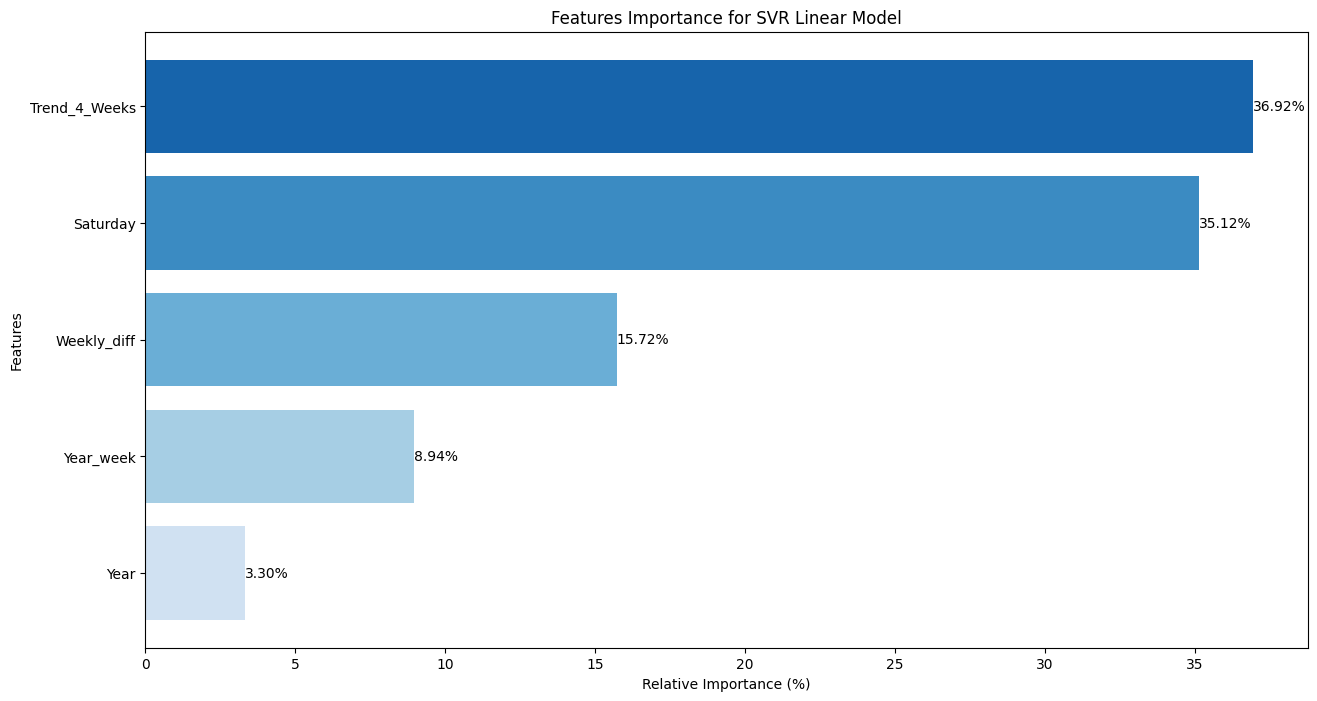

In [87]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming importance_df is already created as per your previous code

# Generate a gradient of blue colors from dark to light
colors = plt.cm.Blues(np.linspace(0.8, 0.2, len(importance_df)))

plt.figure(figsize=(15, 8))
bars = plt.barh(importance_df['Feature'], importance_df['Relative Importance'], color=colors)

plt.title('Features Importance for SVR Linear Model')
plt.xlabel('Relative Importance (%)')
plt.ylabel('Features')

# Adding the percentage next to the bars
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}%', va='center')

plt.gca().invert_yaxis()  # Invert the y-axis to have the highest importance at the top
plt.show()


# MLR AND SVR LINEAR OVER TIME  

In [171]:
df

,Week,Year,Year_week,week_screenings,Weekly_diff,Trend_4_Weeks,Week_day_Monday,Week_day_Saturday,Week_day_Sunday,Week_day_Thursday,Week_day_Wednesday
3,2022-04-04,2022,14,139,49.0,95.75,0,1,0,0,0
4,2022-04-18,2022,16,173,34.0,116.00,0,1,0,0,0
5,2022-05-09,2022,19,3,-170.0,101.25,0,1,0,0,0
6,2022-05-23,2022,21,64,61.0,94.75,0,1,0,0,0
7,2022-06-13,2022,24,101,37.0,85.25,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
70,2024-03-18,2024,12,168,-240.0,243.25,0,1,0,0,0
71,2024-03-25,2024,13,198,30.0,243.00,0,1,0,0,0
72,2024-04-01,2024,14,242,44.0,254.00,0,1,0,0,0
73,2024-04-15,2024,16,186,-56.0,198.50,0,1,0,0,0


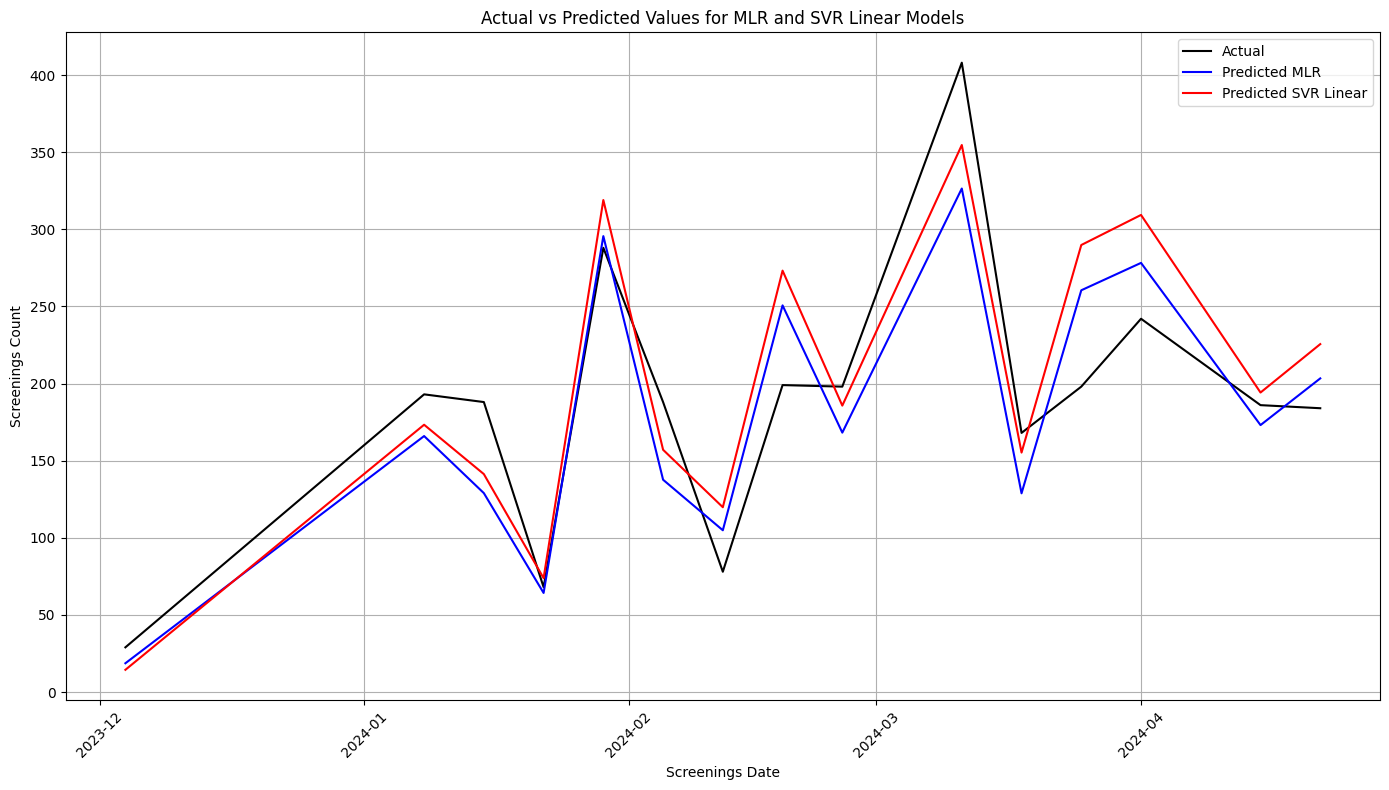

In [31]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming y_test, y_pred_mlr, y_pred_svr_linear, and Week are already defined

# Creating a DataFrame to hold the actual and predicted values
results_df = pd.DataFrame({
    'Week': df.loc[y_test.index, 'Week'],  # Match the Week with the y_test indices
    'Actual': y_test,
    'Predicted_MLR': y_pred_mlr,
    'Predicted_SVR_Linear': y_pred_svr
})

# Plotting the actual vs predicted values
plt.figure(figsize=(14, 8))
plt.plot(results_df['Week'], results_df['Actual'], label='Actual', color='black')
plt.plot(results_df['Week'], results_df['Predicted_MLR'], label='Predicted MLR', color='blue')
plt.plot(results_df['Week'], results_df['Predicted_SVR_Linear'], label='Predicted SVR Linear', color='red')

plt.title('Actual vs Predicted Values for MLR and SVR Linear Models')
plt.xlabel('Screenings Date')
plt.ylabel('Screenings Count')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# HYBRID MLR + SVR

In [32]:
# Make predictions with both models
y_pred_mlr = model_mlr.predict(X_test)
y_pred_svr = model_svr_linear.predict(X_test)

# Create a hybrid prediction by averaging the predictions from both models
y_pred_hybrid = (y_pred_mlr + y_pred_svr) / 2

# Calculate and print the evaluation metrics for the hybrid model
mae = mean_absolute_error(y_test, y_pred_hybrid)
mse = mean_squared_error(y_test, y_pred_hybrid)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_hybrid)
me = np.mean(y_test - y_pred_hybrid)
mav = np.mean(np.abs(y_pred_hybrid))
mpv = np.mean(np.abs((y_test - y_pred_hybrid) / y_test))
rme = np.mean((y_test - y_pred_hybrid) / y_test)
rmae = np.mean(np.abs(y_test - y_pred_hybrid) / np.abs(y_test))

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")
print(f"ME: {me}")
print(f"MAV: {mav}")
print(f"MPV: {mpv}")
print(f"RME: {rme}")
print(f"RMAE: {rmae}")


MAE: 34.87642320809341
MSE: 1726.1863640243848
RMSE: 41.54739900432258
R2: 0.7725936039712126
ME: -2.0521754765104183
MAV: 189.71884214317708
MPV: 0.20631521355156227
RME: -0.008098503925522494
RMAE: 0.20631521355156227


In [39]:
# Assign weights to each model's predictions
weight_mlr = 0.6
weight_svr = 0.4

# Create a hybrid prediction by weighted averaging
y_pred_hybrid = (weight_mlr * y_pred_mlr) + (weight_svr * y_pred_svr)

# Calculate and print the evaluation metrics for the hybrid model
mae = mean_absolute_error(y_test, y_pred_hybrid)
mse = mean_squared_error(y_test, y_pred_hybrid)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_hybrid)
me = np.mean(y_test - y_pred_hybrid)
mav = np.mean(np.abs(y_pred_hybrid))
mpv = np.mean(np.abs((y_test - y_pred_hybrid) / y_test))
rme = np.mean((y_test - y_pred_hybrid) / y_test)
rmae = np.mean(np.abs(y_test - y_pred_hybrid) / np.abs(y_test))

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")
print(f"ME: {me}")
print(f"MAV: {mav}")
print(f"MPV: {mpv}")
print(f"RME: {rme}")
print(f"RMAE: {rmae}")


MAE: 34.70955027864899
MSE: 1698.8996818153917
RMSE: 41.217710778443184
R2: 0.7761883294249946
ME: -0.17759599689716007
MAV: 187.84426266356385
MPV: 0.20340991309560072
RME: 0.0013231363415524074
RMAE: 0.20340991309560072


In [40]:
from sklearn.linear_model import LinearRegression

# Make predictions with both models
y_pred_mlr = model_mlr.predict(X_test)
y_pred_svr = model_svr_linear.predict(X_test)

# Combine the predictions into a new feature set
X_stack = np.column_stack((y_pred_mlr, y_pred_svr))

# Train a meta-learner (e.g., linear regression) on the combined predictions
stacking_model = LinearRegression()
stacking_model.fit(X_stack, y_test)

# Make predictions with the stacking model
y_pred_hybrid = stacking_model.predict(X_stack)

# Calculate and print the evaluation metrics for the hybrid model
mae = mean_absolute_error(y_test, y_pred_hybrid)
mse = mean_squared_error(y_test, y_pred_hybrid)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_hybrid)
me = np.mean(y_test - y_pred_hybrid)
mav = np.mean(np.abs(y_pred_hybrid))
mpv = np.mean(np.abs((y_test - y_pred_hybrid) / y_test))
rme = np.mean((y_test - y_pred_hybrid) / y_test)
rmae = np.mean(np.abs(y_test - y_pred_hybrid) / np.abs(y_test))

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")
print(f"ME: {me}")
print(f"MAV: {mav}")
print(f"MPV: {mpv}")
print(f"RME: {rme}")
print(f"RMAE: {rmae}")


MAE: 33.14128781915351
MSE: 1550.3155332773163
RMSE: 39.37404644276882
R2: 0.7957626850277553
ME: 4.9264296346033615e-14
MAV: 187.6666666666666
MPV: 0.21803085049824744
RME: -0.07211105628969434
RMAE: 0.21803085049824744


# MLP NN MODEL

In [124]:
from sklearn.neural_network import MLPRegressor

In [125]:
# Definir o modelo MLP com uma camada oculta de 100 neurônios (você pode ajustar os parâmetros conforme necessário)
model_mlp = MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)

# Ajustar o modelo aos dados de treino
model_mlp.fit(X_train, y_train)

# "Summary" do modelo
print(f"Coefs: {model_mlp.coefs_}")
print(f"Intercepts: {model_mlp.intercepts_}")
print(f"Número de iterações: {model_mlp.n_iter_}")

# Fazer previsões no conjunto de teste
y_pred = model_mlp.predict(X_test)

# Calcular e imprimir as métricas de avaliação
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
me = np.mean(y_test - y_pred)
mav = np.mean(np.abs(y_test))
mpv = np.mean(np.abs((y_test - y_pred) / y_test))
rme = np.mean((y_test - y_pred) / y_test)
rmae = np.mean(np.abs(y_test - y_pred) / np.abs(y_test))

Coefs: [array([[-4.82893869e-02,  2.00031147e-01,  9.80716947e-02,
         3.54574306e-02, -1.45705580e-01, -1.45716589e-01,
        -1.90616820e-01,  1.61032328e-01,  5.80534624e-02,
         1.06828141e-01, -2.07900177e-01,  2.09728889e-01,
         1.45217140e-01, -1.20093913e-01, -1.33945283e-01,
        -1.33226744e-01, -7.88917494e-02,  1.47719121e-03,
        -2.45374417e-02, -8.46636852e-02,  4.16440625e-02,
        -1.53255020e-01, -8.42567858e-02, -5.17851735e-02,
        -1.51785780e-02,  1.43732653e-01, -1.25835255e-01,
        -3.93278606e-03,  5.39341273e-02, -1.95974369e-01,
         6.11179201e-02, -1.39090515e-01, -1.87409737e-01,
         2.21279443e-01,  2.29144936e-01,  1.33858271e-01,
        -7.87273454e-02, -1.72417063e-01,  9.71037983e-02,
        -2.12977419e-02, -1.61243861e-01, -1.18289187e-02,
        -2.01533425e-01,  1.81134155e-01, -9.91568034e-02,
         6.53128892e-02, -7.55910915e-02,  2.00842281e-02,
         1.08948204e-02, -1.32567297e-01,  2.095

In [126]:
print("Modelo: MPL NN")
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')
print(f'ME: {me}')
print(f'MAV: {mav}')
print(f'MPV: {mpv}')
print(f'RME: {rme}')
print(f'RMAE: {rmae}')

# Modelo: MPL NN shuffle
# MAE: 148.3347019043649
# MSE: 27076.336014730532
# RMSE: 164.54888639772233
# R2: -2.567014616208236
# ME: 146.82547236537584
# MAV: 187.66666666666666
# MPV: 0.7724405248428579
# RME: 0.7203981269466838
# RMAE: 0.7724405248428579

# split
# MAE: 187.0672249603031
# MSE: 38566.619157129644
# RMSE: 196.38385666120737
# R2: -4.679635632584995
# ME: 187.0672249603031
# MAV: 231.0
# MPV: 0.8229719060012978
# RME: 0.8229719060012978
# RMAE: 0.8229719060012978

Modelo: MPL NN
MAE: 148.3347019043649
MSE: 27076.336014730532
RMSE: 164.54888639772233
R2: -2.567014616208236
ME: 146.82547236537584
MAV: 187.66666666666666
MPV: 0.7724405248428579
RME: 0.7203981269466838
RMAE: 0.7724405248428579


# LSTM

In [127]:
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM, Dense # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from sklearn.preprocessing import MinMaxScaler

In [103]:
# Normalizar os dados de entrada
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)

# Redimensionar os dados para o formato [samples, timesteps, features]
# Como não temos uma série temporal específica, vamos usar a janela temporal de 1 (ou seja, cada amostra é seu próprio timestep)
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Dividir novamente os dados em treino e teste após a normalização
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

In [109]:
# Convertendo a coluna 'Semana' para datetime, se ainda não foi feito
df['Semana'] = pd.to_datetime(df['Semana'])

# Definir a data de corte para divisão de treino e teste
split_date = '2024-03-01'

# Criar conjuntos de treino e teste com base na data
train_indices = df['Semana'] < split_date
test_indices = df['Semana'] >= split_date

X_train = X_scaled[train_indices]
X_test = X_scaled[test_indices]
y_train = y[train_indices]
y_test = y[test_indices]

In [110]:
model = Sequential()
model.add(LSTM(50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Fazer previsões
y_pred = model.predict(X_test)

c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


In [111]:
# Flatten y_pred to make it a 1D array
y_pred = y_pred.flatten()

# Calcular e imprimir as métricas de avaliação
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
me = np.mean(y_test - y_pred)
mav = np.mean(np.abs(y_test))
mpv = np.mean(np.abs((y_test - y_pred) / y_test))
rme = np.mean((y_test - y_pred) / y_test)
rmae = np.mean(np.abs(y_test - y_pred) / np.abs(y_test))

In [112]:
print("Modelo: LSTM")
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')
print(f'ME: {me}')
print(f'MAV: {mav}')
print(f'MPV: {mpv}')
print(f'RME: {rme}')
print(f'RMAE: {rmae}')

# split
# MAE: 231.02939052383104
# MSE: 60165.80682230465
# RMSE: 245.28719253622813
# R2: -7.860507965087891
# ME: 231.02939052383104
# MAV: 231.0
# MPV: 1.000131884852717
# RME: 1.000131884852717
# RMAE: 1.000131884852717

# shuffle
# MAE: 187.7007750702401
# MSE: 42822.52245702975
# RMSE: 206.936034699203
# R2: -4.641404151916504
# ME: 187.7007750702401
# MAV: 187.66666666666666
# MPV: 1.0003038314357109
# RME: 1.0003038314357109
# RMAE: 1.0003038314357109



Modelo: LSTM
MAE: 231.06084231783947
MSE: 60178.417555503016
RMSE: 245.3128972465635
R2: -7.86236572265625
ME: 231.06084231783947
MAV: 231.0
MPV: 1.0002955252907542
RME: 1.0002955252907542
RMAE: 1.0002955252907542


# XGB MODEL

In [128]:
from xgboost import XGBRegressor

In [129]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[2])

AttributeError: 'DataFrame' object has no attribute 'reshape'

In [139]:
model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [140]:
# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test)

# Calcular e imprimir as métricas de avaliação
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
me = np.mean(y_test - y_pred)
mav = np.mean(np.abs(y_test))
mpv = np.mean(np.abs((y_test - y_pred) / y_test))
rme = np.mean((y_test - y_pred) / y_test)
rmae = np.mean(np.abs(y_test - y_pred) / np.abs(y_test))

In [141]:
print("Modelo: XGB")
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')
print(f'ME: {me}')
print(f'MAV: {mav}')
print(f'MPV: {mpv}')
print(f'RME: {rme}')
print(f'RMAE: {rmae}')

# Modelo: XGB shuffle
# MAE: 73.98568153381348
# MSE: 7209.577884115871
# RMSE: 84.90923320885587
# R2: 0.05021613836288452
# ME: 68.51750831604004
# MAV: 187.66666666666666
# MPV: 0.40753031454348826
# RME: 0.3868808936660607
# RMAE: 0.40753031454348826

#split
# Modelo: XGB
# MAE: 39.60233052571615
# MSE: 2827.3205278721484
# RMSE: 53.172554272595825
# R2: 0.5836256742477417
# ME: 35.99457295735677
# MAV: 231.0
# MPV: 0.15086300530722507
# RME: 0.1312556272183154
# RMAE: 0.15086300530722507

Modelo: XGB
MAE: 39.60233052571615
MSE: 2827.3205278721484
RMSE: 53.172554272595825
R2: 0.5836256742477417
ME: 35.99457295735677
MAV: 231.0
MPV: 0.15086300530722507
RME: 0.1312556272183154
RMAE: 0.15086300530722507
